In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from WoLF_lib import *

# Single run of WoLF-PHC

In [4]:
a,b,c=WoLF_PHC(0.3, 0.6, 0.2, 0.95, np.linspace(0,1,7), 500000)

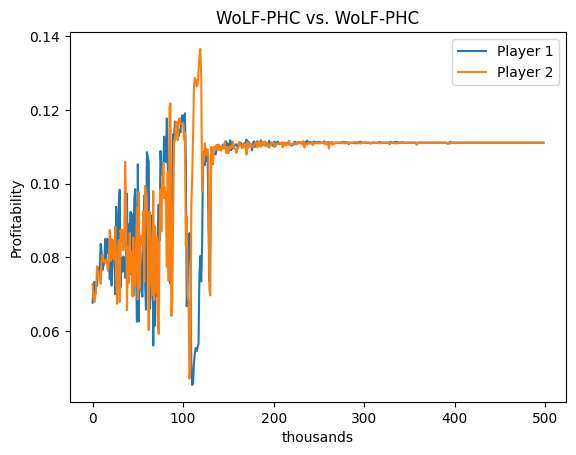

In [5]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, a)
plt.plot(x_values, b)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('WoLF-PHC vs. WoLF-PHC')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

# Joint profit maximizing


In [2]:
avg_prof,avg_prof_gain= run_sim_wolf(1000, np.linspace(0,1,7))

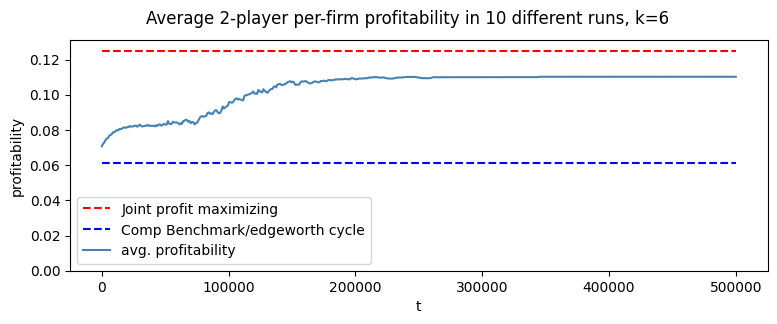

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [6]:
avg_prof[498]

0.11021141975308733

# Price cycles

In [7]:
b, c, p,_,_ = WoLF_PHC(0.3, 0.6, 0.2, 0.95, np.linspace(0,1,49), 500000)
p1 = p[0,499950:500000]
p2 = p[1,499950:500000]

plt.figure(figsize=(12, 3))
p0s2d = p1[np.arange(0, p1.size, 2)][:-1]
p1s2d = p2[np.arange(1, p2.size, 2)][:-1]

plt.xlabel("t")
plt.ylabel("price")
plt.plot(range(0, 48, 2), p0s2d , label="firm 0 prices", marker="o", color="yellowgreen", linestyle="dotted")
plt.plot(range(1, 48, 2), p1s2d, label="firm 1 prices", marker="o", color="purple", linestyle="dotted")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ValueError: not enough values to unpack (expected 5, got 3)

# Forced deviation

In [ ]:
Monk, profits, avg_2pp1,avg2pp2,avg_profitabilities= run_sim_wolf_FD(100,7)

In [ ]:
MAnkA = Monk[0,::2]
MAnkaB = Monk[1,::2]

### Average price

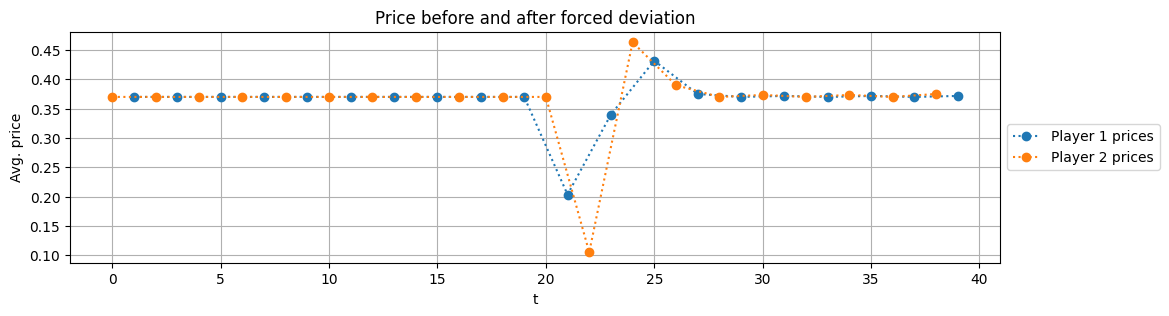

In [ ]:
xvalues = range(len(MAnkA[249965:249985]))
#print(p2)
#print(new)
# Plot the array as a line graph
plt.figure(figsize=(12, 3))
plt.plot(range(1,len(xvalues)*2,2), MAnkA[249965:249985], marker="o", linestyle='dotted')
plt.plot(range(0,len(xvalues)*2,2), MAnkaB[249965:249985], marker="o", linestyle='dotted')
#plt.plot(xvalues, p2, marker="o", linestyle='dotted')

# Add labels and title
plt.grid()
plt.xlabel('t')
plt.ylabel('Avg. price')
plt.title('Price before and after forced deviation')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

### Average Two-Period Profit

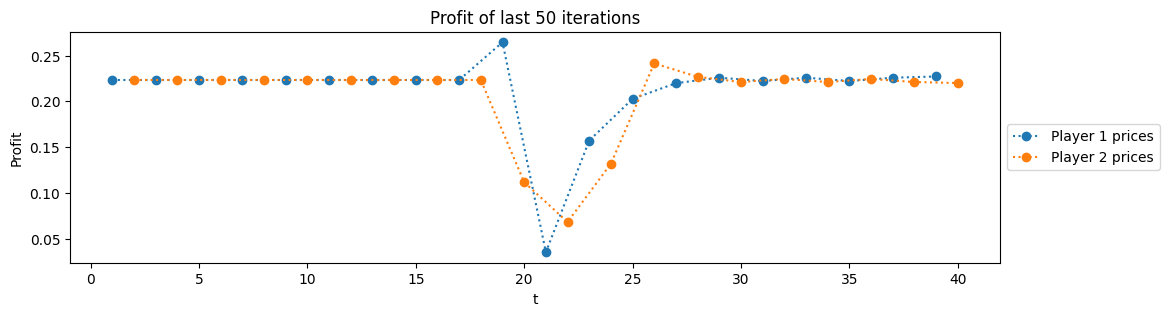

In [ ]:
zoom1 = avg_profitabilities[0,249965:249985]
zoom2 = avg_profitabilities[1,249965:249985]
#print("Last 50 prices for player 1: \n", p1)
#print("Last 50 prices for player 2: \n", p2)


xvalues = range(len(zoom1))
plt.figure(figsize=(12, 3))
# Plot the array as a line graph
plt.plot(range(1,len(xvalues)*2,2), zoom1, marker="o", linestyle='dotted')
plt.plot(range(2,len(xvalues)*2+1,2), zoom2, marker="o", linestyle='dotted')

# Add labels and title
plt.xlabel('t')
plt.ylabel('Profit')
plt.title('Profit of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

### Average market price

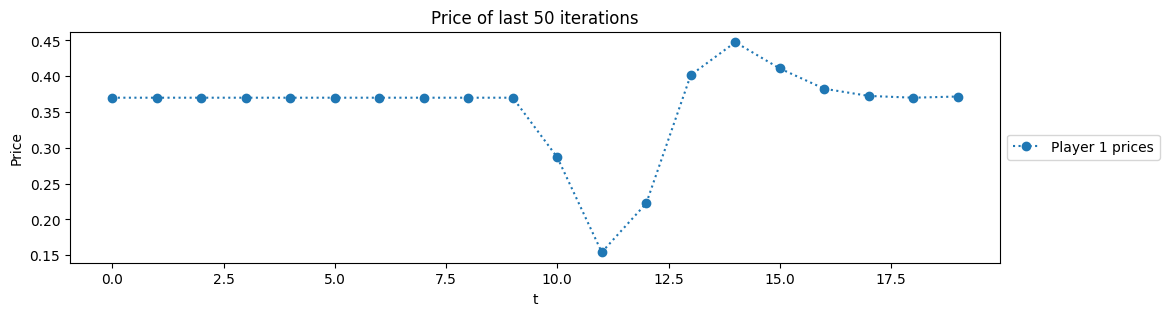

In [ ]:
p1 = Monk[0,499940:499960]
p2 = Monk[1,499940:499960]


new=[]
for i in range(len(p1)):
    res=(p1[i]+p2[i])/2
    new.append(res)

xvalues = range(len(new))
plt.figure(figsize=(12, 3))

# Plot the array as a line graph
plt.plot(xvalues, new, marker="o", linestyle='dotted')


# Add labels and title
plt.xlabel('t')
plt.ylabel('Price')
plt.title('Price of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

## Assymetric information

In [ ]:
a,b,c=WoLF_PHC_asymmetric(0.3, 0.6, 0.2, 0.95, np.linspace(0,1,7), 500000)

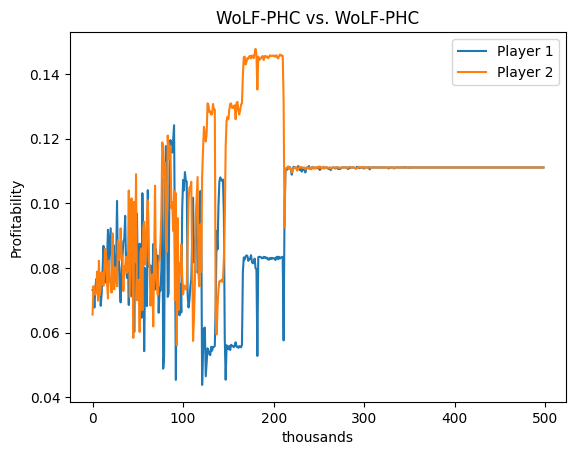

In [ ]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, a)
plt.plot(x_values, b)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('WoLF-PHC vs. WoLF-PHC')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [13]:
avg_prof_asym, avg_prof_gain_asym= run_sim_wolf_asym(1000, k=7, mu=0.025)

In [14]:
avg_prof_asym[498]

0.10706018518518606

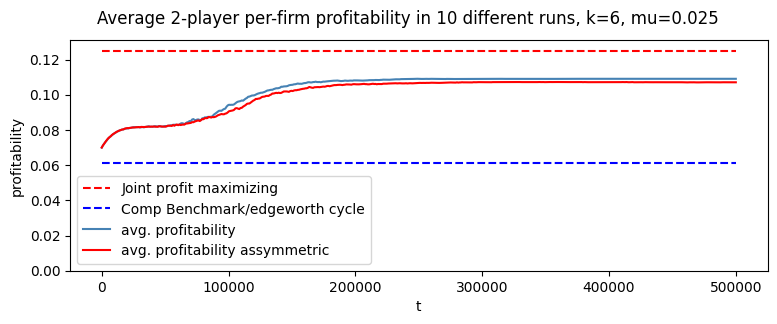

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}, mu={}".format(10, 6, 0.025))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.plot(xs, avg_prof_asym, color="red", label = "avg. profitability assymmetric")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [10]:
avg_prof_asym[498]

0.10968280022446793

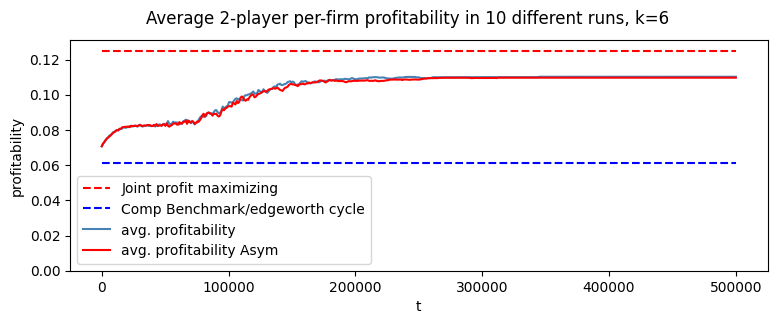

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.plot(xs, avg_prof_asym, color="red", label = "avg. profitability Asym")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [12]:
avg_prof_asym[498]

0.10968280022446793

In [13]:
avg_prof[498]

0.11021141975308733